In [ ]:
# 'PAR_Tot_Tot', 'PAR_Den_Min', 'PAR_Den_Max', 'PAR_Den_Avg'

In [1]:
###############
## Data load ##
###############
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


data_ori = pd.read_csv('/content/GW_afterEDA_12h.csv')
#data['Date'] = pd.to_datetime(data['Date'])
#df.set_index('time', inplace = True)  # shape (43640, 15)
data_ori = data_ori.drop(columns=['TempC_Avg', 'Date', 'LeafNumber', 'PlantHeight', 'PetioleLength', 'LeafLength', 'LeafWidth', 'CrownDiameter']).assign(TempC_Avg=data_ori['TempC_Avg']) ############ 변경
data_ori.head()

,T,EC,VWC,TempC_Min,TempC_Max,PAR_Tot_Tot,PAR_Den_Min,PAR_Den_Max,PAR_Den_Avg,CO2_Avg,TempC_Avg
0,15.810139,0.165681,0.245854,13.675437,14.676042,59.549850,54.887719,154.035721,99.992374,0.0,14.239861
1,22.579931,0.175139,0.247500,18.893264,19.712083,44.340682,57.856332,94.552280,73.901132,0.0,19.269167
2,18.353750,0.167375,0.247118,16.071806,16.648333,73.238805,71.353288,167.402699,122.064667,0.0,16.360139
3,24.888403,0.197660,0.245035,19.159444,20.185347,69.139318,85.073911,150.221413,115.232192,0.0,19.684792
4,17.671736,0.175208,0.245799,13.529104,15.047451,59.019791,64.324488,126.557827,98.366316,0.0,14.439813


In [2]:
data = data_ori[['TempC_Avg', 'PAR_Den_Avg']]
data['RTR'] = data.mean(axis = 1)
data.head()

<ipython-input-2-8e6a58fa303d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RTR'] = data.mean(axis = 1)


,TempC_Avg,PAR_Den_Avg,RTR
0,14.239861,99.992374,57.116117
1,19.269167,73.901132,46.585149
2,16.360139,122.064667,69.212403
3,19.684792,115.232192,67.458492
4,14.439813,98.366316,56.403064


In [3]:
df = pd.concat([data_ori, data['RTR']], axis = 1)
df = df.drop(columns=['TempC_Avg']).assign(TempC_Avg=data_ori['TempC_Avg'])
df.head()

,T,EC,VWC,TempC_Min,TempC_Max,PAR_Tot_Tot,PAR_Den_Min,PAR_Den_Max,PAR_Den_Avg,CO2_Avg,RTR,TempC_Avg
0,15.810139,0.165681,0.245854,13.675437,14.676042,59.549850,54.887719,154.035721,99.992374,0.0,57.116117,14.239861
1,22.579931,0.175139,0.247500,18.893264,19.712083,44.340682,57.856332,94.552280,73.901132,0.0,46.585149,19.269167
2,18.353750,0.167375,0.247118,16.071806,16.648333,73.238805,71.353288,167.402699,122.064667,0.0,69.212403,16.360139
3,24.888403,0.197660,0.245035,19.159444,20.185347,69.139318,85.073911,150.221413,115.232192,0.0,67.458492,19.684792
4,17.671736,0.175208,0.245799,13.529104,15.047451,59.019791,64.324488,126.557827,98.366316,0.0,56.403064,14.439813


<Axes: >

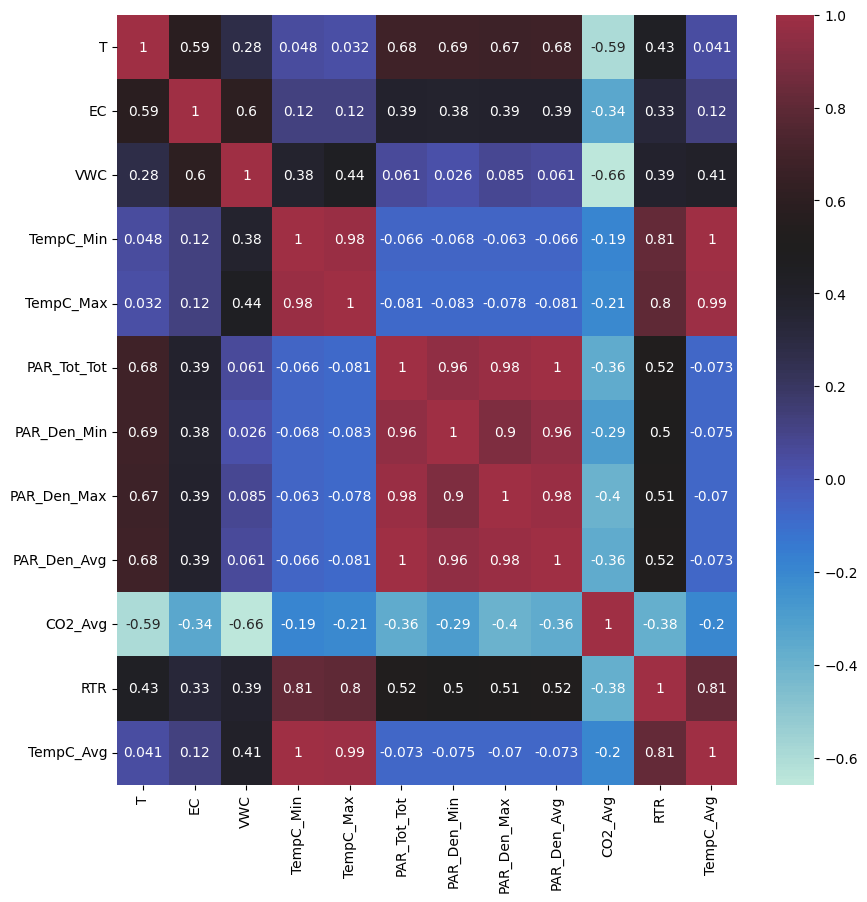

In [4]:
df_corr = df.corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(df_corr, center=0.5, annot=True)

In [5]:
# lag feature
def create_lag_features(df, lags=14):
  y = df.loc[:, "TempC_Avg"]
  for lag in range(lags):
    df[f"lag_{lag + 1}"] = y.shift(lag + 1)
  return df

df2 = create_lag_features(df, lags=14)
df2 = df2.drop(columns=['TempC_Avg']).assign(TempC_Avg=df2['TempC_Avg'])

In [6]:
df2.isnull().sum()

T               0
EC              0
VWC             0
TempC_Min       0
TempC_Max       0
PAR_Tot_Tot     0
PAR_Den_Min     0
PAR_Den_Max     0
PAR_Den_Avg     0
CO2_Avg         0
RTR             0
lag_1           1
lag_2           2
lag_3           3
lag_4           4
lag_5           5
lag_6           6
lag_7           7
lag_8           8
lag_9           9
lag_10         10
lag_11         11
lag_12         12
lag_13         13
lag_14         14
TempC_Avg       0
dtype: int64

In [7]:
df2.fillna(0, inplace = True)

In [8]:
df2.isnull().sum()

T              0
EC             0
VWC            0
TempC_Min      0
TempC_Max      0
PAR_Tot_Tot    0
PAR_Den_Min    0
PAR_Den_Max    0
PAR_Den_Avg    0
CO2_Avg        0
RTR            0
lag_1          0
lag_2          0
lag_3          0
lag_4          0
lag_5          0
lag_6          0
lag_7          0
lag_8          0
lag_9          0
lag_10         0
lag_11         0
lag_12         0
lag_13         0
lag_14         0
TempC_Avg      0
dtype: int64

In [9]:
df2.head(20)

,T,EC,VWC,TempC_Min,TempC_Max,PAR_Tot_Tot,PAR_Den_Min,PAR_Den_Max,PAR_Den_Avg,CO2_Avg,...,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,TempC_Avg
0,15.810139,0.165681,0.245854,13.675437,14.676042,59.549850,54.887719,154.035721,99.992374,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.239861
1,22.579931,0.175139,0.247500,18.893264,19.712083,44.340682,57.856332,94.552280,73.901132,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.269167
2,18.353750,0.167375,0.247118,16.071806,16.648333,73.238805,71.353288,167.402699,122.064667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.360139
3,24.888403,0.197660,0.245035,19.159444,20.185347,69.139318,85.073911,150.221413,115.232192,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.684792
4,17.671736,0.175208,0.245799,13.529104,15.047451,59.019791,64.324488,126.557827,98.366316,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.439813
5,24.446319,0.198958,0.246194,8.917493,13.686382,63.160217,78.462461,139.863826,105.267022,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.320472
6,16.508194,0.176569,0.246812,14.449986,17.718764,44.299932,46.756662,112.044045,73.833216,0.0,...,14.239861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.155521
7,21.585139,0.190396,0.247951,18.240764,18.894583,52.467262,52.054840,135.585807,87.445434,0.0,...,19.269167,14.239861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.571736
8,14.898750,0.168681,0.249451,12.833514,13.402076,68.164769,62.070634,151.118014,113.607940,0.0,...,16.360139,19.269167,14.239861,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.124847
9,22.323889,0.190750,0.249521,18.557083,19.494306,59.138843,65.178949,150.506510,98.564737,0.0,...,19.684792,16.360139,19.269167,14.239861,0.000000,0.000000,0.000000,0.000000,0.000000,19.033194


### LightGBM

In [ ]:
!pip install optuna

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optuna Libraries
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import lightgbm as lgb
from lightgbm import LGBMRegressor

def split_data(df, target_col, test_size=0.2, shuffle = False):
    feature_columns = list(df.columns.difference([target_col]))
    X = df[feature_columns]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = False)
    return X_train, X_test, y_train, y_test
target_col = "TempC_Avg"
X_train, X_test, y_train, y_test = split_data(df2, target_col)

X_train.shape


(180, 25)

In [13]:
scaler11 = StandardScaler()
scaler22 = StandardScaler()
X_train = scaler11.fit_transform(X_train)
X_test = scaler11.fit_transform(X_test)

y_train_array = np.array(y_train)
y_train_reshape = y_train_array.reshape(-1, 1)
y_train = scaler22.fit_transform(y_train_reshape)

y_test_array = np.array(y_test)
y_test_reshape = y_test_array.reshape(-1, 1)
y_test = scaler22.fit_transform(y_test_reshape)

In [ ]:
model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print('TempC_Avg MSE: {:.4f}'.format(mse))
print('TempC_Avg MAE: {:.4f}'.format(mae))
print('TempC_Avg RMSE: {:.4f}'.format(rmse))
print('TempC_Avg R^2: {:.4f}'.format(r2))
'''
TempC_Avg MSE: 0.3005
TempC_Avg MAE: 0.4681
TempC_Avg RMSE: 0.5481
TempC_Avg R^2: 0.6995
'''

In [16]:
y_test_array = np.array(y_test) #series를 numpy로 변환
y_test_array=y_test_array.reshape(-1, 1) # 변경
y_test_inverse = scaler22.inverse_transform(y_test_array)

y_pred_array = np.array(y_pred)
y_pred_array = y_pred_array.reshape(-1, 1)
y_pred_inverse = scaler22.inverse_transform(y_pred_array)

# y_test_inverse, y_pred_inverse를 1차원 배열로 변환
y_test_inverse = np.ravel(y_test_inverse)
y_pred_inverse = np.ravel(y_pred_inverse)

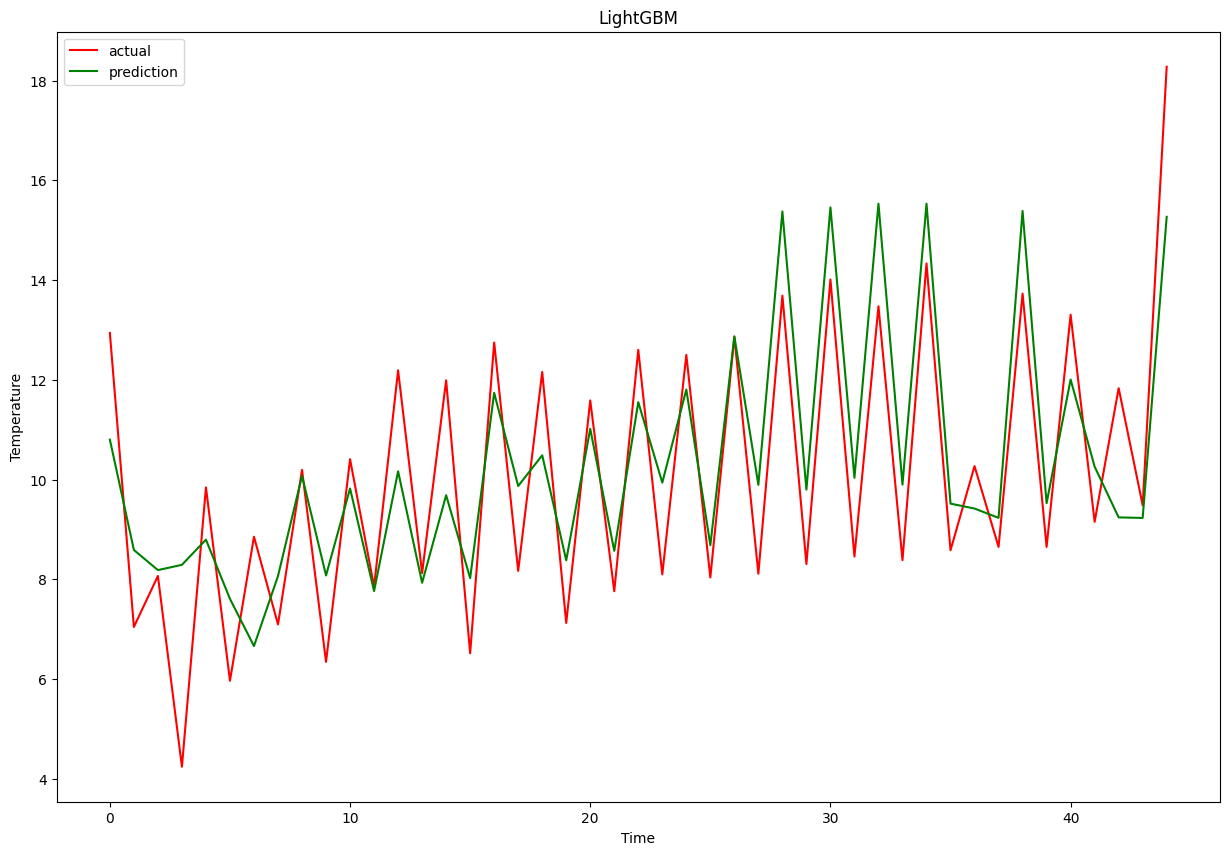

In [19]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_inverse, label='actual', color='red')
plt.plot(y_pred_inverse, label='prediction', color='green')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('LightGBM')
plt.legend()
plt.show()

### XGBoost

In [20]:
from xgboost import XGBRegressor
model2 = XGBRegressor()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

mse = mean_squared_error(y_test, y_pred2)
mae = mean_absolute_error(y_test, y_pred2)
rmse = np.sqrt(mean_squared_error(y_test, y_pred2))
r2 = r2_score(y_test, y_pred2)
print('TempC_Avg MSE: {:.4f}'.format(mse))
print('TempC_Avg MAE: {:.4f}'.format(mae))
print('TempC_Avg RMSE: {:.4f}'.format(rmse))
print('TempC_Avg R^2: {:.4f}'.format(r2))

TempC_Avg MSE: 0.1664
TempC_Avg MAE: 0.2653
TempC_Avg RMSE: 0.4079
TempC_Avg R^2: 0.8336


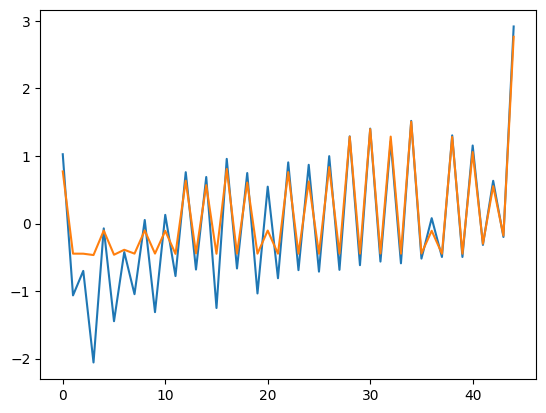

In [21]:
plt.plot(y_test)
plt.plot(y_pred2)

In [22]:
y_test_array = np.array(y_test) #series를 numpy로 변환
y_test_array=y_test_array.reshape(-1, 1) # 변경
y_test_inverse = scaler22.inverse_transform(y_test_array)

y_pred2_array = np.array(y_pred2)
y_pred2_array = y_pred2_array.reshape(-1, 1)
y_pred2_inverse = scaler22.inverse_transform(y_pred2_array)

# y_test_inverse, y_pred_inverse를 1차원 배열로 변환
y_test_inverse = np.ravel(y_test_inverse)
y_pred_inverse = np.ravel(y_pred2_inverse)

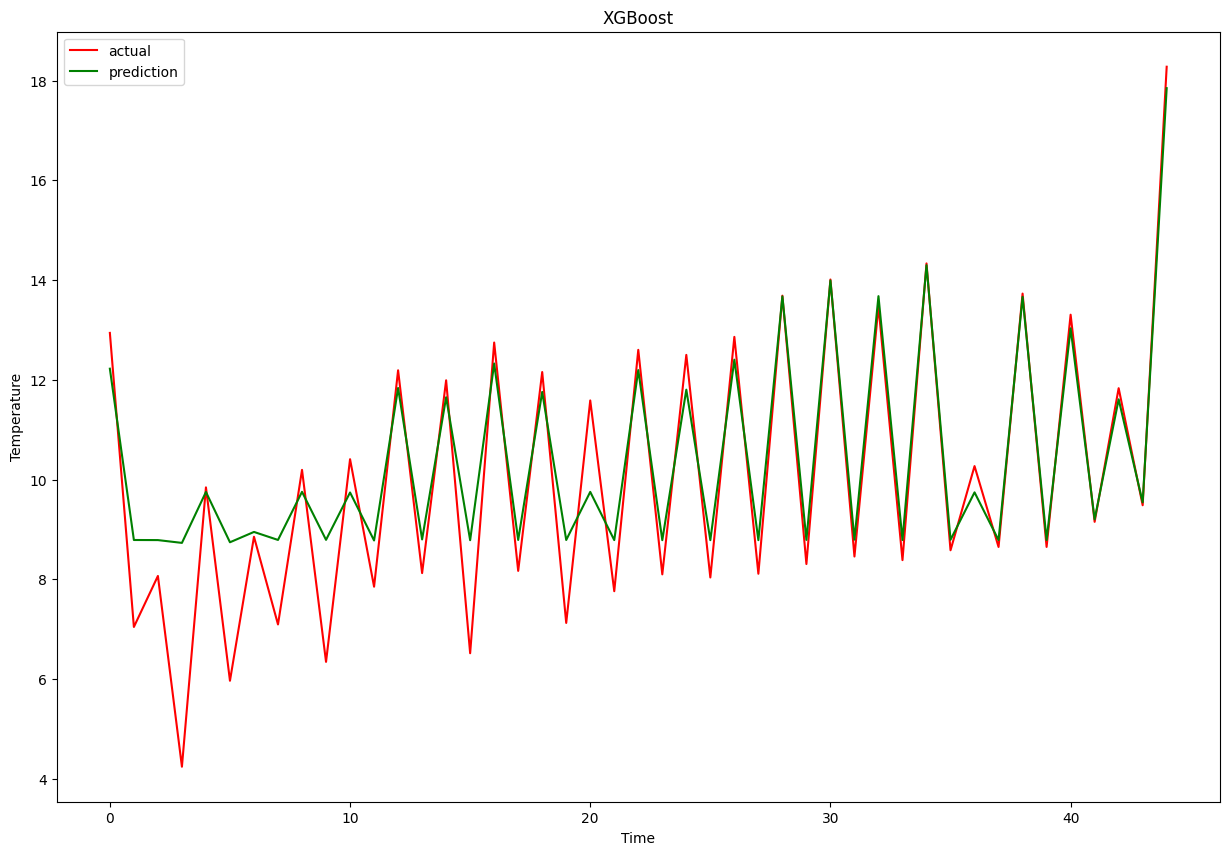

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(y_test_inverse, label='actual', color='red')
plt.plot(y_pred_inverse, label='prediction', color='green')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('XGBoost')
plt.legend()
plt.show()